[*********************100%%**********************]  1 of 1 completed
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frederik135. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 10.7 K
1 | criterion | MSELoss   | 0     
----------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 67/67 [00:00<00:00, 137.50it/s, v_num=mugz, train_loss_step=3.07e-7, val_loss_step=6.66e-5, val_loss_epoch=4.23e-5, train_loss_epoch=1.77e-5]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 67/67 [00:00<00:00, 77.57it/s, v_num=mugz, train_loss_step=3.07e-7, val_loss_step=6.66e-5, val_loss_epoch=4.23e-5, train_loss_epoch=1.77e-5] 


Restoring states from the checkpoint path at .\RNN_single_step_forecasts\21pzmugz\checkpoints\epoch=99-step=6700.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\RNN_single_step_forecasts\21pzmugz\checkpoints\epoch=99-step=6700.ckpt


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 348.09it/s]

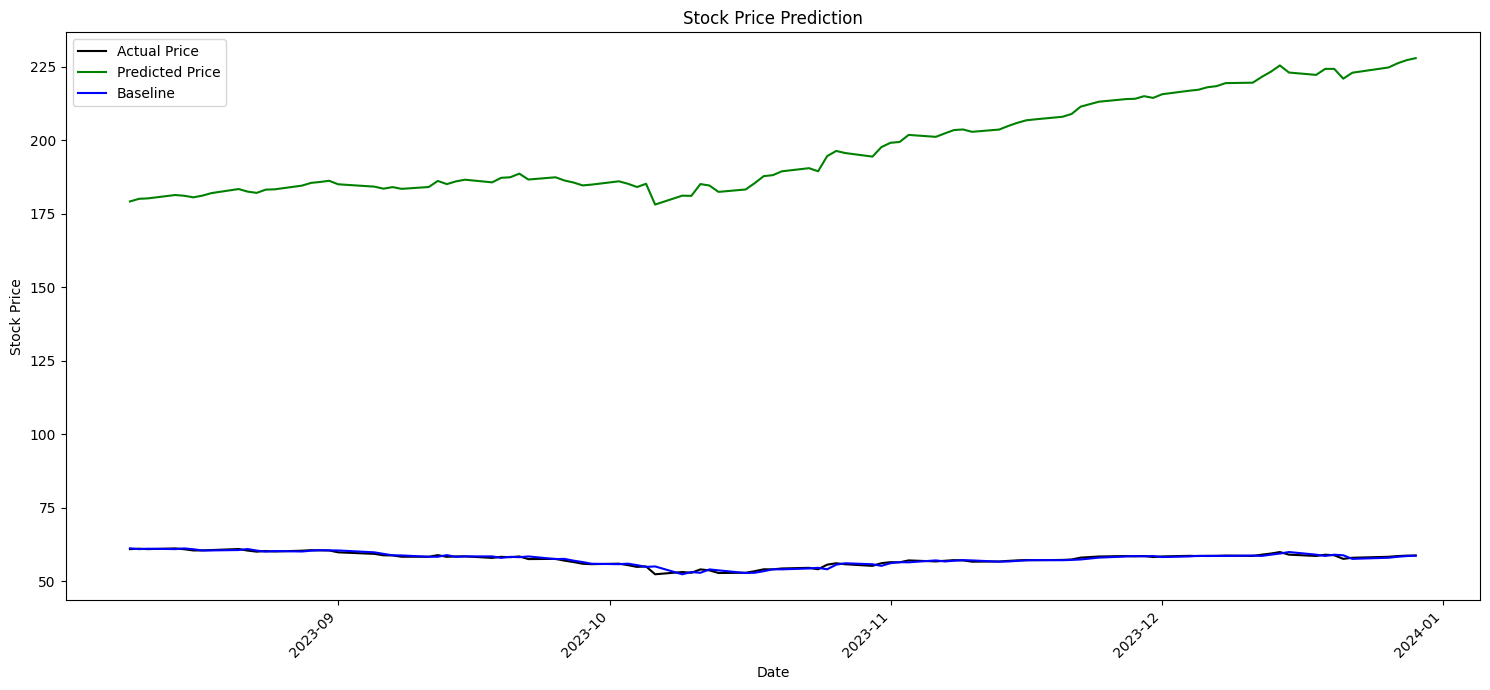

Testing DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         3.0110348234302364e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁
train_loss_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁▂▂▂▂▂▂▁▂▁▃▄█▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▁▁▁▁▃▁▁▁▁▄▁▄▁▁▂▂▂▂▆▂▂▂▂▇▂▇▂▂█▂█▂▂▂
val_loss_epoch,█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▂▂▂▁▁▁
val_loss_step,▂▁▂▄▁▂▄▁▂▁▁▂▁▁▂█▂▂█▂▁▂▃▁▂▃▁▂▁▁▂▁▁▁▃▁▁▂▁▁
epoch,100
test_loss,3e-05
train_loss_epoch,2e-05
train_loss_step,0.0


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import wandb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima import auto_arima
from models import RNNModel, LSTMModel, GRUModel
from config import architecture, seq_length, num_epochs, learning_rate, wandb_config, model_config
from preprocessing import stock_df, features_df, labels


class StockPredictionModule(pl.LightningModule):
    def __init__(self, model, label_scaler, train_loader, val_loader, test_loader, test_dates):
        super().__init__()
        self.model = model
        self.label_scaler = label_scaler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.test_dates = test_dates
        self.criterion = nn.MSELoss()
        # self.criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', label_smoothing=0.0)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        seqs, labels = batch
        y_pred = self(seqs)
        loss = self.criterion(y_pred, labels)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        predictions, actuals = [], []
        for seqs, labels in self.test_loader:
            seqs, labels = seqs.to(self.device), labels.to(self.device)
            output = self(seqs)
            predictions.extend(output.view(-1).detach().cpu().numpy())
            actuals.extend(labels.view(-1).detach().cpu().numpy())

        len_test_set = len(predictions)

        predictions_rescaled = list(self.label_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten())
        actuals_rescaled = list(self.label_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten())

        """
        # Test gemacht: actuals ist um eins zu weit nach rechts verschoben, verglichen mit dem selben Index der Preise im stock_df Dataframe. 
        # Daher verschieben wir es hier um eins nach links
        actuals_rescaled = actuals_rescaled[1:]
        predictions_rescaled = predictions_rescaled[1:]
        """ 

        print(" ")
        print(" ")
        print(predictions_rescaled) 
        print(actuals_rescaled)
        print(" ")
        print(" ")       

        actual_closing_prices = stock_df['Close'].values[-len_test_set:]

        actual_prices = [actual_closing_prices[0]]
        for i in range(1, len(actuals_rescaled)):
            current_actual_price = actual_prices[-1] * actuals_rescaled[i]
            actual_prices.append(current_actual_price)
        
        prediction_prices = [actual_closing_prices[0]]
        for i in range(1, len(predictions_rescaled)):
            current_prediction_price = prediction_prices[-1] * predictions_rescaled[i]
            prediction_prices.append(current_prediction_price)
        
        
        """
        print(" ")
        print(" ")
        print(actuals_rescaled[:10])
        print(actual_closing_prices[:10])
        print(actual_prices)
        print(len(actuals_rescaled))
        print(len(actual_closing_prices))
        print(len(actual_prices))
        print(" ")
        print(" ")
        """
        # prediction_prices = predictions_rescaled
        # actual_prices = actuals_rescaled
        baseline_prices = [actual_prices[0]] + actual_prices[:-1]

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(self.test_dates[-100:], actual_prices[-100:], label='Actual Price', color='black', linestyle='-')
        ax.plot(self.test_dates[-100:], prediction_prices[-100:], label='Predicted Price', color='green', linestyle='-')
        ax.plot(self.test_dates[-100:], baseline_prices[-100:], label='Baseline', color='blue', linestyle='-')
        ax.set_title('Stock Price Prediction')
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.legend()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.tight_layout()
        plt.plot()
        plt.show()
        
        filename = "plot.png"
        fig.savefig(filename)
        wandb.log({"Stock Price Prediction": wandb.Image(filename)})
        os.remove(filename)
        plt.close(fig)

        actual_prices = np.array(actual_prices)
        prediction_prices = np.array(prediction_prices)
        baseline_prices = np.array(baseline_prices)

        model_mse = mean_squared_error(actual_prices, prediction_prices)
        model_rmse = np.sqrt(model_mse)
        model_mae = mean_absolute_error(actual_prices, prediction_prices)
        model_r2 = r2_score(actual_prices, prediction_prices)
        model_mape = np.mean(np.abs((actual_prices - prediction_prices) / actual_prices))
        
        baseline_mse = mean_squared_error(actual_prices, baseline_prices)
        baseline_rmse = np.sqrt(baseline_mse)
        baseline_mae = mean_absolute_error(actual_prices, baseline_prices)
        baseline_r2 = r2_score(actual_prices, baseline_prices)
        baseline_mape = np.mean(np.abs((actual_prices - baseline_prices) / (actual_prices + 1e-8)))

        model_metrics = {
            "mse": model_mse,
            "rmse": model_rmse,
            "mae": model_mae,
            "mape": model_mape,
            "r2": model_r2,
        }

        baseline_metrics = {
            "mse": baseline_mse,
            "rmse": baseline_rmse,
            "mae": baseline_mae,
            "mape": baseline_mape,
            "r2": baseline_r2,
        }

        model_baseline_performance_metrics = {
            "mse": round((baseline_mse / model_mse - 1) * 100, 2),
            "rmse": round((baseline_rmse / model_rmse - 1) * 100, 2),
            "mae": round((baseline_mae / model_mae - 1) * 100, 2),
            "mape": round((baseline_mape / model_mape - 1) * 100, 2),
            "r2": round((model_r2 / baseline_r2 - 1) * 100, 2),
        }

        metrics_table = wandb.Table(columns=["metric", "model", "baseline", "model-baseline performance comparison [%]"])
        for metric in model_metrics.keys():
            metrics_table.add_data(metric, model_metrics[metric], baseline_metrics[metric], model_baseline_performance_metrics[metric])
        wandb.log({"metrics": metrics_table})


def create_sequences(data, labels):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = labels[i + seq_length - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)


def load_data():
    total_length = len(features_df)
    split_idx = int(total_length * 0.8) + seq_length
    val_test_idx = int(total_length * 0.9) + seq_length

    train_df = features_df.iloc[:split_idx]
    val_df = features_df.iloc[split_idx:val_test_idx]
    test_df = features_df.iloc[val_test_idx:]

    train_labels = labels[:split_idx]
    val_labels = labels[split_idx:val_test_idx]
    test_labels = labels[val_test_idx:]

    # Normalizing each feature individually
    feature_scaler = {}
    train_normalized = train_df.copy()
    val_normalized = val_df.copy()
    test_normalized = test_df.copy()

    for column in train_df.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_normalized[column] = scaler.fit_transform(train_df[column].values.reshape(-1, 1)).flatten()
        val_normalized[column] = scaler.transform(val_df[column].values.reshape(-1, 1)).flatten()
        test_normalized[column] = scaler.transform(test_df[column].values.reshape(-1, 1)).flatten()
        feature_scaler[column] = scaler

    label_scaler = MinMaxScaler(feature_range=(-1, 1))
    train_labels_scaled = label_scaler.fit_transform(train_labels.reshape(-1, 1))
    val_labels_scaled = label_scaler.transform(val_labels.reshape(-1, 1))
    test_labels_scaled = label_scaler.transform(test_labels.reshape(-1, 1))

    X_train, y_train = create_sequences(train_normalized.values, train_labels_scaled.flatten())
    X_val, y_val = create_sequences(val_normalized.values, val_labels_scaled.flatten())
    X_test, y_test = create_sequences(test_normalized.values, test_labels_scaled.flatten())

    test_dates = features_df.index[-(len(X_test) + seq_length):].tolist()
    test_dates = test_dates[seq_length:]
    
    train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)), batch_size=64, shuffle=False, 
                                               num_workers=15, persistent_workers=True)
    val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=64, shuffle=False, 
                                             num_workers=15, persistent_workers=True)
    test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)), batch_size=64, shuffle=False, 
                                              num_workers=15, persistent_workers=True)

    return train_loader, val_loader, test_loader, label_scaler, test_dates

def main():
    torch.set_float32_matmul_precision("medium")
    wandb_logger = WandbLogger(project="RNN_single_step_forecasts", log_model="all", config=wandb_config)
    train_loader, val_loader, test_loader, label_scaler, test_dates = load_data()

    if architecture == "RNN":
        model = RNNModel(**model_config)
    elif architecture == "LSTM":
        model = LSTMModel(**model_config)
    elif architecture == "GRU":
        model = GRUModel(**model_config)
    else:
        raise ValueError("Unsupported architecture specified")

    module = StockPredictionModule(model=model, label_scaler=label_scaler,
                                   train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, test_dates = test_dates)

    # Device agnostic initialization
    if torch.cuda.is_available():   # Check for GPU availability
        accelerator = "gpu"
        devices = 1
    elif hasattr(torch, 'has_mps') and torch.backends.mps.is_built():  # Check for MPS availability (Apple Silicon)
        accelerator = "mps"
        devices = 1
    else:
        accelerator = None  # Defaults to CPU
        devices = None  # Ignored for CPU

    trainer = Trainer(max_epochs=num_epochs, logger=wandb_logger, accelerator=accelerator, devices=devices, enable_checkpointing=True)
    trainer.fit(module, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(dataloaders=test_loader, ckpt_path="best")

    wandb.finish()

if __name__ == "__main__":
    main()



In [ ]:
# pip install optuna

# Hyperparamter tuning

import optuna
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 128)

    # Update model config
    model_config.update({
        "hidden_layer_size": hidden_size,
        "num_layers": num_layers
    })

    # Create the model with new hyperparameters
    model = RNNModel(**model_config)

    # Setup data
    train_loader, val_loader, _, _, _, _, _ = load_data()

    # Create the PyTorch Lightning module
    pl_module = StockPredictionModule(model=model, optimizer=torch.optim.Adam, learning_rate=learning_rate)

    # Trainer setup with Early Stopping
    trainer = Trainer(
        logger=False,
        checkpoint_callback=False,
        max_epochs=50,
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)],
        progress_bar_refresh_rate=0
    )
    
    # Training the model
    trainer.fit(pl_module, train_loader, val_loader)

    # Evaluate the model
    val_result = trainer.validate(pl_module, val_dataloaders=val_loader, verbose=False)
    val_loss = val_result[0]['val_loss']

    return val_loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_trial.params)

In [ ]:
from preprocessing import stock_df, labels
print(labels)